# Modèle de classement des textos en spam

on cherche à entraîner un modèle capable de prédire si un texto est un spam ou non. 

On s'appuie pour cela sur une base de données contenant des sms labellisés comme spam ou non spam (ham)

source : 
* https://archive.ics.uci.edu/ml/datasets.php
* readme  

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Taille-des-messages" data-toc-modified-id="Taille-des-messages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Taille des messages</a></span></li></ul></li><li><span><a href="#nettoyage" data-toc-modified-id="nettoyage-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>nettoyage</a></span></li><li><span><a href="#Matrice-de-termes" data-toc-modified-id="Matrice-de-termes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Matrice de termes</a></span></li><li><span><a href="#Nettoyage-2" data-toc-modified-id="Nettoyage-2-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Nettoyage 2</a></span><ul class="toc-item"><li><span><a href="#Liste-de-stop-words" data-toc-modified-id="Liste-de-stop-words-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Liste de stop words</a></span></li></ul></li><li><span><a href="#Nuage-de-mots" data-toc-modified-id="Nuage-de-mots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Nuage de mots</a></span><ul class="toc-item"><li><span><a href="#Split" data-toc-modified-id="Split-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Split</a></span></li><li><span><a href="#Entrainement-avec-randomforest" data-toc-modified-id="Entrainement-avec-randomforest-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Entrainement avec randomforest</a></span></li><li><span><a href="#Matrice-de-confusion" data-toc-modified-id="Matrice-de-confusion-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Matrice de confusion</a></span></li><li><span><a href="#ACP" data-toc-modified-id="ACP-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>ACP</a></span></li><li><span><a href="#RFR---RandomForestRegressor" data-toc-modified-id="RFR---RandomForestRegressor-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>RFR - RandomForestRegressor</a></span></li><li><span><a href="#Courbe-ROC" data-toc-modified-id="Courbe-ROC-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Courbe ROC</a></span></li></ul></li><li><span><a href="#Autre-solution" data-toc-modified-id="Autre-solution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Autre solution</a></span><ul class="toc-item"><li><span><a href="#fct-rm_punctuation" data-toc-modified-id="fct-rm_punctuation-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>fct rm_punctuation</a></span></li><li><span><a href="#fc-tokenize" data-toc-modified-id="fc-tokenize-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>fc tokenize</a></span></li><li><span><a href="#fct-rm_stopwords" data-toc-modified-id="fct-rm_stopwords-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>fct rm_stopwords</a></span></li><li><span><a href="#On-en-est-où" data-toc-modified-id="On-en-est-où-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>On en est où</a></span></li><li><span><a href="#nb-de-mots" data-toc-modified-id="nb-de-mots-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>nb de mots</a></span></li></ul></li><li><span><a href="#rF" data-toc-modified-id="rF-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>rF</a></span></li><li><span><a href="#Wordcloud" data-toc-modified-id="Wordcloud-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Wordcloud</a></span><ul class="toc-item"><li><span><a href="#Split-ham-spam" data-toc-modified-id="Split-ham-spam-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Split ham spam</a></span></li><li><span><a href="#binarisation" data-toc-modified-id="binarisation-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>binarisation</a></span></li></ul></li></ul></div>

- Faites un nuage de mots par catégorie pour bien illustrer les différences des mots utilisés entre spam et non spam.

- À partir de la matrice de termes réduite, entraînez un modèle de forêts aléatoires permettant de prédire si un texto est un spam ou non 

- Essayez d'améliorer la prédiction de votre modèle en ajoutant une analyse en composantes principales en amont.

On peut imaginer que pour une entreprise qui développe cette solution, on souhaite plus à minimiser l'erreur consistant à définir comme spam un texto qui n'en est pas un (erreur de type 1, "faux positif") plutôt que de rater quelques spams : 
- Utilisez votre dernier modèle pour prédire des probabilités que le texto soit un spam. À partir de quelle valeur de cette probabilité notre modèle ne classe aucun non spam en spam?

## Import

In [59]:
import pandas as pd
import re
import string
import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, auc

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words

from collections import Counter

%matplotlib inline

- Import de la base de données dans un dataframe

In [2]:
data = pd.read_table('data/SMSSpamCollection.txt', header=None)
data.columns = names=["label", "texte"]

## Exploratory Data Analysis (EDA)

In [3]:
data.head(3)

,label,texte
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
len(data)

5572

In [5]:
data.dtypes

label    object
texte    object
dtype: object

In [6]:
data.describe()

,label,texte
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   texte   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
data.shape

(5572, 2)

In [9]:
data.columns

Index(['label', 'texte'], dtype='object')

In [10]:
pd.crosstab(index=data["label"],columns="count")

col_0,count
label,
ham,4825
spam,747


```python
sns.countplot(data)
plt.xlabel('Label')
plt.title('Nb')```

In [11]:
data.groupby('label').describe()

texte                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

### Taille des messages

In [12]:
data['length'] = data['texte'].apply(len)
data.head()

,label,texte,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


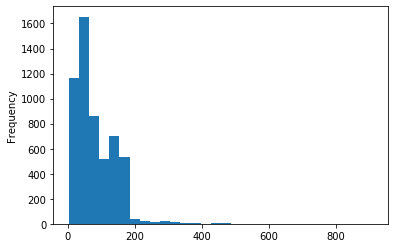

In [13]:
data['length'].plot(bins=30,kind = 'hist')

In [14]:
data['length'].describe()

count    5572.000000
mean       80.490309
std        59.944527
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [15]:
data[data['length'] == 910]['texte'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [16]:
data.head(4)

,label,texte,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49


## nettoyage

* Transformations usuelles du texte pour faciliter l'analyse textuelle

In [17]:
#```python
def premier_nettoyage(text):
    text = text.lower() # passage en minuscules
    #text = re.sub(f"[{string.punctuation}]", " ", text) # on enlève la ponctuation  
    #text = re.sub("[0-9]", "", text) # On enlève les références au minutages
    #text = re.sub(r"\xa0", " ", text) # caractère spécial hypertexte
    text = re.sub("\d", "", text) # On enlève les chiffres
    return text
#```

In [18]:
#```python
data["clean"] = data.texte.apply(lambda x: premier_nettoyage(x))
#data_clean = pd.DataFrame(df_sms.texte.apply(lambda x: nettoyage(x)))
#```

## Matrice de termes

- Faites une matrice de termes et affichez les termes les plus fréquents dans chaque catégorie : spam ou non spam. Si nécessaire, enrichissez la liste de stop-words pour limiter la taille de la matrice.

In [19]:
cv = CountVectorizer(stop_words = "english")

In [20]:
# fit_transform 
mdt = cv.fit_transform(data["clean"])
mdt_textos_all = pd.DataFrame(mdt.toarray(), columns = cv.get_feature_names())
mdt_textos_all.index = data.label
mdt_textos_all

,____,aa,aah,aaniye,aaooooright,aathi,ab,abbey,abdomen,abeg,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,èn,〨ud
label,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Nettoyage 2

In [21]:
sum_mots = mdt_textos_all.groupby("label").sum()
sum_mots_t = sum_mots.transpose()
sum_mots_t

label,ham,spam
____,2,0
aa,1,0
aah,3,0
aaniye,1,0
aaooooright,1,0
...,...,...
zouk,0,1
zs,0,1
zyada,1,0
èn,1,0


In [22]:
# On peut supprimer quand le nombre d'occurences représente moins de 1% des observations
nb_occurences = pd.DataFrame()
for i in ["ham", "spam"]:
    nb_occurences[i] = sum_mots_t[i]/len(mdt_textos_all[mdt_textos_all.index == i]) 

part_occu_max = nb_occurences.max(axis = 1)

In [23]:
additional_sw = part_occu_max[part_occu_max<=0.01].index.values
list_sw = []
for i in additional_sw:
    list_sw.append(i)
additional_sw

array(['____', 'aa', 'aah', ..., 'zyada', 'èn', '〨ud'], dtype=object)

### Liste de stop words

In [24]:
stop_words = text.ENGLISH_STOP_WORDS.union(additional_sw)

In [25]:
type(stop_words)

frozenset

In [28]:
cv = CountVectorizer(stop_words = stop_words)
# On refait la matrice de distances ainsi : 
mdt = cv.fit_transform(data["clean"])
mdt_textos = pd.DataFrame(mdt.toarray(), columns = cv.get_feature_names())
mdt_textos.index = data.label

In [29]:
type(mdt_textos)

pandas.core.frame.DataFrame

In [31]:
mdt_textos.head()

,ac,account,admirer,age,amp,answer,anytime,apply,area,ask,...,word,work,worth,www,xmas,xxx,ya,yeah,yes,yr
label,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
spam = sum_mots_t[["spam"]]
non_spam = sum_mots_t[["ham"]]

In [33]:
spam.sort_values(by='spam', ascending = False).head(20)

label,spam
free,226
txt,170
ur,144
mobile,128
stop,126
text,126
claim,113
reply,104
www,98
prize,93


In [34]:
non_spam.sort_values(by='ham', ascending = False).head(20)

label,ham
gt,318
lt,316
just,297
ok,288
ll,266
ur,247
know,237
good,235
like,234
got,234


## Nuage de mots

In [37]:
dict_spam_ham = {}
for i in ["ham", "spam"]:
    dict_spam_ham[i] = ''.join(data["clean"][data.label == i])

In [38]:
type(dict_spam_ham)

dict

In [39]:
dict_spam_ham

AttributeError: 'dict' object has no attribute 'head'

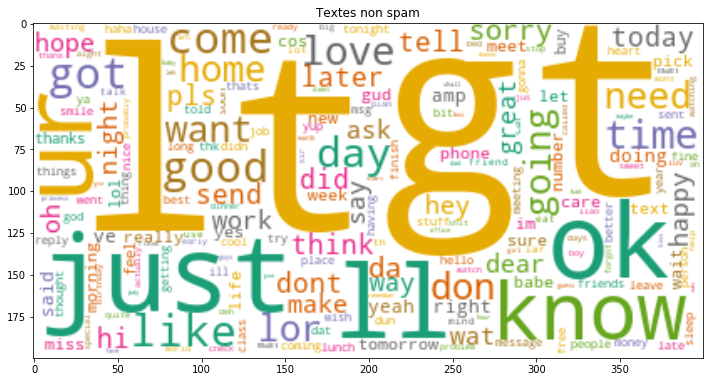

In [44]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

wc.generate_from_frequencies(non_spam.ham)

plt.imshow(wc, interpolation="bilinear")
plt.title("Textes non spam")
plt.rcParams["figure.figsize"] = (12,12)
plt.show()

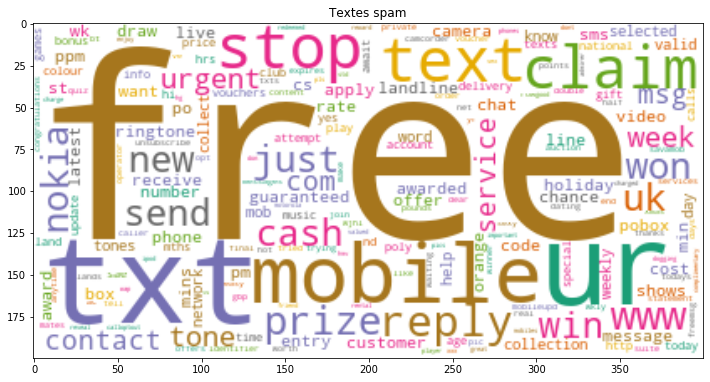

In [43]:
wc.generate_from_frequencies(spam.spam)

plt.imshow(wc, interpolation="bilinear")
plt.title("Textes spam")
plt.rcParams["figure.figsize"] = (12,12)
plt.show()

### Split

In [45]:
# On splite notre matrice en entraînement et test
from sklearn.model_selection import train_test_split
y = 1 * (mdt_textos.index == "spam")

X_train, X_test, y_train, y_test = train_test_split(mdt_textos, y, test_size=0.2)
X_train.shape

(4457, 349)

### Entrainement avec randomforest

In [48]:
# On entraîne le modèle de randomforest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
rf.score(X_test, y_test)

0.9775784753363229

### Matrice de confusion

In [51]:
cm = confusion_matrix(y_test, rf.predict(X_test))
cm = pd.DataFrame(cm, columns=["Prédit non spam", "Prédit spam"])
cm.index = ["Vrai non spam", "Vrai spam"]
cm

,Prédit non spam,Prédit spam
Vrai non spam,961,5
Vrai spam,20,129


### ACP

In [53]:
# On entraîne notre ACP
pca = PCA(0.60)
pca.fit(X_train)
pca.n_components_ # on affiche le nombre de composantes

55

In [54]:
# on transforme nos X train et X test
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### RFR - RandomForestRegressor

In [55]:
# On entraîne le modèle de randomforest
rf = RandomForestClassifier()
rf.fit(X_train_pca, y_train)
# on affiche le score
rf.score(X_test_pca, y_test)

0.9802690582959641

In [56]:
# Le nombre d'erreurs de type 1 en fonction d'un seuil de décision se fixe ainsi :  
predictions = rf.predict_proba(X_test_pca)
y_pred = 1 * (predictions[:, 1] > 0.80)
erreur_type_1 = y_pred[y_test == 0].sum()
erreur_type_1

2

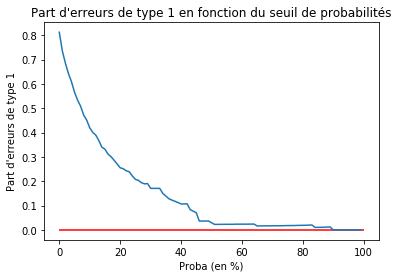

In [57]:
# On fait un graphe pour voir à quel niveau on ne prédit plus un spam à tort
proba = [i for i in range(0, 100, 1)]

# On en profite pour calculer aussi les erreurs de type 2 : les faux négatifs, c'est à dire les spams prédits comme non spams
erreur_type_1 = []
erreur_type_2 = []
for i in proba:
    y_pred = 1 * (predictions[:, 1] > i/100)
    erreur_type_1.append(y_pred[y_test == 0].sum()/(y_pred == 1).sum())
    erreur_type_2.append(y_test[y_pred == 0].sum()/(y_pred == 0).sum())
    
plt.plot(proba, erreur_type_1)
plt.xlabel("Proba (en %)")
plt.ylabel("Part d'erreurs de type 1")
plt.title("Part d'erreurs de type 1 en fonction du seuil de probabilités")
plt.hlines(y = 0, xmin = 0, xmax = 100, color = "red")
plt.show()

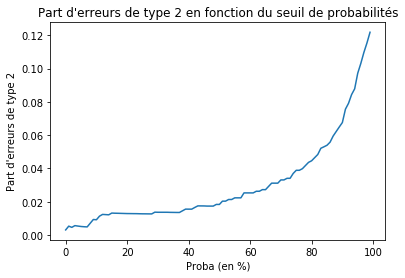

In [58]:
plt.plot(proba, erreur_type_2)
plt.xlabel("Proba (en %)")
plt.ylabel("Part d'erreurs de type 2")
plt.title("Part d'erreurs de type 2 en fonction du seuil de probabilités")
plt.show()

### Courbe ROC

In [60]:
fpr0, tpr0, thresholds0 = roc_curve(y_test, predictions[:, 1], 
                                    pos_label=rf.classes_[1], 
                                    drop_intermediate=False)

In [61]:
tp = pd.DataFrame(dict(taux_faux_spams=fpr0, taux_vrais_spams=tpr0, threshold=thresholds0)).copy()
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2
tp

,taux_faux_spams,taux_vrais_spams,threshold
1,0.000000,0.100671,1.000000
2,0.000000,0.154362,0.990000
3,0.000000,0.201342,0.980000
4,0.000000,0.248322,0.970000
5,0.000000,0.255034,0.966000
...,...,...,...
283,0.659420,0.986577,0.000064
284,0.659420,0.993289,0.000052
285,0.661491,0.993289,0.000034
286,0.663561,0.993289,0.000016


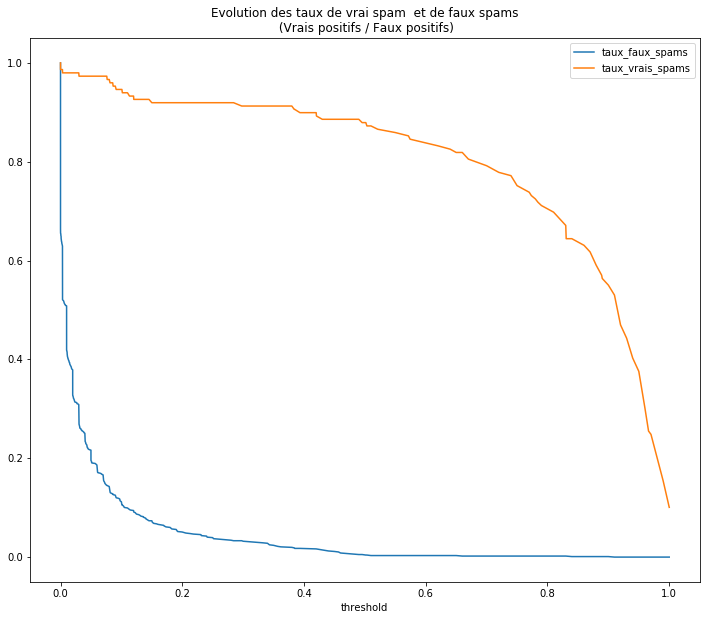

In [62]:
ax = tp.plot(x="threshold", y=['taux_faux_spams', 'taux_vrais_spams'], figsize=(12,10))
ax.set_title("Evolution des taux de vrai spam  et de faux spams\n (Vrais positifs / Faux positifs)");

## Autre solution

### fct rm_punctuation

In [19]:
def rm_punctuation(text):
    new_text=''.join([char for char in text if char not in string.punctuation])
    return new_text

In [20]:
data['new_text']=data['texte'].apply(lambda row : rm_punctuation(row))

### fc tokenize

In [21]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens

In [83]:
data['tokenized_text']=data['new_text'].apply(lambda row : tokenize(row.lower()))
data.head()

,label,texte,length,new_text,tokenized_text
0,0,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,0,U dun say so early hor... U c already then say...,49,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


### fct rm_stopwords

In [84]:
eng_stop_words = get_stop_words('english')
#eng_stop_words
type(eng_stop_words)

list

In [85]:
STOPWORDS = eng_stop_words + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
type(STOPWORDS)

list

In [86]:
def rm_stopwords(text):
    clean_text = [word for word in text if word not in STOPWORDS]
    return clean_text 

In [87]:
#data['clean_text']=data['tokenized_text'].apply(lambda row : rm_stopwords(row))

### On en est où

In [88]:
data.shape, type(data)

((5572, 5), pandas.core.frame.DataFrame)

In [89]:
data.head(3)

,label,texte,length,new_text,tokenized_text
0,0,"Go until jurong point, crazy.. Available only ...",111,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."


In [97]:
data['texte'].iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [98]:
data.loc[0].values

array([0,
       'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       111,
       'Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat',
       list(['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat'])],
      dtype=object)

In [107]:
data.texte.loc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [106]:
data.new_text

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in 2 a wkly comp to win FA Cup fina...
3             U dun say so early hor U c already then say
4       Nah I dont think he goes to usf he lives aroun...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                  Will ü b going to esplanade fr home
5569    Pity  was in mood for that Soany other suggest...
5570    The guy did some bitching but I acted like id ...
5571                            Rofl Its true to its name
Name: new_text, Length: 5572, dtype: object

In [104]:
cv = CountVectorizer(stop_words = eng_stop_words)

In [109]:
data = cv.fit_transform(data.new_text)
data_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names())

AttributeError: new_text not found

In [ ]:
data_dtm.index = data.index
data_dtm

### nb de mots

In [ ]:
def word_count(texte):
    frequency_list = []
    for i in preprocessed_documents:
        frequency_list.append(Counter(i))
    return frequency_list

```python
words = data[data.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))```

## rF

In [113]:
X_train, X_test, y_train, y_test = train_test_split(data['texte'], 
                                                    data['label'], 
                                                    random_state=1)

IndexError: Index dimension must be <= 2

## Wordcloud

### Split ham spam

In [55]:
data_ham  = data[data['label'] == 'spam'].copy()
data_spam = data[data['label'] == 'spam'].copy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
### 

In [ ]:
="".join(data.texte)

### binarisation

In [17]:
data['label'] = data.label.map({'ham':0, 'spam':1})

In [18]:
data.shape

(5572, 3)

In [19]:
data.head(4)

,label,texte,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
